In [1]:
import pandas as pd
import numpy as np
import os
import hddm

import glob
import re

import nideconv

import matplotlib.pyplot as plt
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## First, re-do deconvolutions

In [4]:
## load all extracted signals
all_csvs = glob.glob('./derivatives/ds-*/extracted_signal/sub-*/func/*subroi*.csv')

reg = re.compile('.*ds-(?P<ds>\d+)/extracted_signal/sub-(?P<sub>\d+)/func/sub-.*_task-randomdotmotion_run-(?P<run>\d+)_space-T1w_desc-preproc_desc-stn(?P<hemisphere>\S+)_subroi-(?P<roi>\S)_roi.*')
reg.match(all_csvs[1]).groupdict()

{'ds': '01', 'hemisphere': 'r', 'roi': 'A', 'run': '01', 'sub': '19'}

In [7]:
df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    d['signal'] = pd.read_csv(fn, index_col=0).mean(1)
    d = pd.DataFrame(d)
    d['t'] = np.arange(0, d.shape[0]*3, 3)
    
    df.append(d)

df = pd.concat(df, axis=0)
df['ds'] = df['ds'].astype(int)
df['run'] = df['run'].astype(int)
df['sub'] = df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = df.loc[df.ds==1,'sub'].max()
df.loc[df.ds==2,'sub'] = df.loc[df.ds==2,'sub']+max_sub_ds1

In [8]:
df_pivoted = df.rename(columns={'sub':'subject'}).pivot_table(values=['signal'], index=['ds', 'subject', 'run', 't'], columns=['hemisphere', 'roi'])
df_pivoted = df_pivoted.reset_index(level=0, drop=True)
df_pivoted.columns = ['_'.join(col) for col in df_pivoted.columns]

df_pivoted.head()

signal_l_A  signal_l_B  signal_l_C  signal_r_A  signal_r_B  \
subject run t                                                                
1       1   0    -0.239806   -0.178589   -0.947851   -0.679461   -1.369150   
            3    -0.551264    0.186332   -0.475592   -0.391721   -1.193000   
            6     0.015289    0.063214   -0.388570   -0.267504   -0.838869   
            9     0.260700    0.141860    0.195549    0.205334   -0.260657   
            12   -0.165794    0.051937    0.033031    0.230826   -0.258694   

                signal_r_C  
subject run t               
1       1   0     0.074469  
            3     0.361400  
            6     0.328726  
            9    -0.294576  
            12    0.980462

In [23]:
## get events
behavior = pd.read_pickle('./derivatives/behavior.pkl')
behavior['sub'] = behavior['subject']
behavior.loc[behavior['ds']=='ds-02', 'sub'] = behavior.loc[behavior['ds']=='ds-02', 'sub'].astype(int) + behavior.loc[behavior['ds']=='ds-01', 'sub'].astype(int).max()
behavior['sub'] = behavior['sub'].astype(int)

events_cue = behavior[['sub', 'block', 'onset_cue']]
events_cue['event_type'] = 'cue'
events_cue = events_cue.rename(columns={'block': 'run', 'onset_cue': 'onset'})

events_stim = behavior[['sub', 'block', 'onset_stim']]
events_stim['event_type'] = 'stim'
events_stim = events_stim.rename(columns={'block': 'run', 'onset_stim': 'onset'})

events = pd.concat((events_cue, events_stim))
events = events.sort_values(by=['sub', 'run', 'onset'])
events = events.rename(columns={'sub': 'subject'})
events.head()

events_deconv = events.set_index(['subject', 'run', 'event_type'])
events_deconv.head()

## correct onsets due to STC
events_deconv['onset'] -= 1.5

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [24]:
## get confounds
all_csvs = glob.glob('./derivatives/ds-*/fmriprep_confounds/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

reg = re.compile('.*ds-(?P<ds>\d+)/fmriprep_confounds/sub-(?P<sub>\d+)_.*_run-(?P<run>\d+)_.*')
reg.match(all_csvs[1]).groupdict()


confounds_df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    tmp = pd.read_csv(fn, sep='\t')
    tmp['sub'] = d['sub']
    tmp['run'] = d['run']
    tmp['ds'] = d['ds']
    confounds_df.append(tmp)

confounds_df = pd.concat(confounds_df, axis=0)
confounds_df['ds'] = confounds_df['ds'].astype(int)
confounds_df['run'] = confounds_df['run'].astype(int)
confounds_df['subject'] = confounds_df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = confounds_df.loc[confounds_df.ds==1,'subject'].max()
confounds_df.loc[confounds_df.ds==2,'subject'] = confounds_df.loc[confounds_df.ds==2,'subject']+max_sub_ds1
confounds_df = confounds_df.sort_values(['ds', 'subject', 'run']).set_index(['ds', 'subject', 'run'])

# Include confounds
confounds_deconv = confounds_df.reset_index(level=0, drop=True)
include_confounds = ['a_comp_cor_0' + str(x) for x in range(5)] + ['cosine' + str(x).zfill(2) for x in range(17)]
include_confounds = include_confounds + ['dvars']
include_confounds = include_confounds + ['rot_' + a for a in ['x', 'y', 'z']]
include_confounds = include_confounds + ['trans_' + a for a in ['x', 'y', 'z']]
confounds_deconv = confounds_deconv[include_confounds]

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## Fourier basis set deconvolution

In [25]:
from nideconv import GroupResponseFitter
    
gmodel = GroupResponseFitter(df_pivoted, 
                             events_deconv, 
                             confounds=confounds_deconv.fillna(0),
                             input_sample_rate=1/3, concatenate_runs=True)
gmodel.add_event('stim', basis_set='fourier', n_regressors=7, interval=[0, 18])
gmodel.add_event('cue', basis_set='fourier', n_regressors=7, interval=[0, 18])

gmodel.fit()

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'N=34')

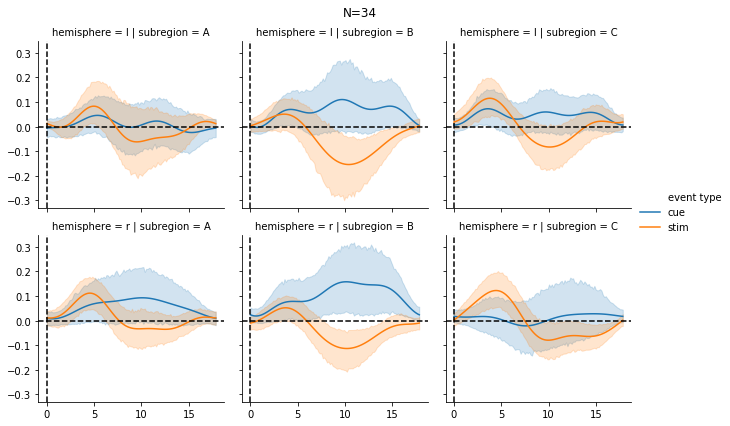

In [28]:
tmp = gmodel.get_subjectwise_timecourses()
tmp = tmp.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

## plot
fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

fac.map_dataframe(sns.lineplot,
                  x='time',
                  hue='event type',
                  y='signal',
                  color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

plt.subplots_adjust(top=0.9)
fac.fig.suptitle('N=34')

## Fit actual GLM
- Regressors at cue: left, right, neural
- Regressors at stimulus: easy, hard, error, left, right

In [518]:
behavior['subject'] = behavior['sub']
behavior['run'] = behavior['block']

cues = behavior[['cue', 'onset_cue', 'subject', 'run']]
cues = cues.rename(columns={'cue': 'event_type', 'onset_cue': 'onset'})
cues['event_type'] = cues['event_type'].replace({'left': 'cue_left', 'right': 'cue_right', 'neutral': 'cue_neutral'})

stimuli = behavior[['difficulty', 'onset_stim', 'subject', 'run']]
stimuli = stimuli.rename(columns={'difficulty': 'event_type', 'onset_stim': 'onset'})

errors = behavior.loc[behavior.correct==0, ['onset_stim', 'subject', 'run']]
errors['event_type'] = 'error'
errors = errors.rename(columns={'onset_stim': 'onset'})

response_direction = behavior[['response', 'onset_stim', 'subject', 'run']]
response_direction = response_direction.loc[response_direction['response']>0]
response_direction['response'] = response_direction['response'].replace({1: 'response_left', 2: 'response_right'})
response_direction = response_direction.rename(columns={'response': 'event_type', 'onset_stim': 'onset'})

# concat everything  IGNORE errors & response direction for now - leads to singular matrix, use ridge?
events = pd.concat([cues, stimuli], 0)[['subject', 'run', 'event_type', 'onset']]
events = events.sort_values(['subject', 'run', 'onset'])
events.set_index(['subject', 'run'])

events['onset'] -= 1.5  # STC

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


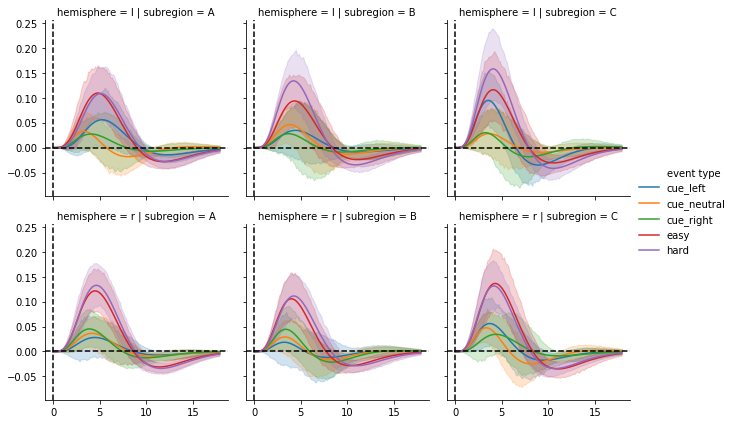

In [519]:
## fit
from nideconv import GroupResponseFitter
gmodel = GroupResponseFitter(df_pivoted, 
                             events, 
                             confounds=confounds_deconv.fillna(0),
                             input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events.event_type.unique():
    gmodel.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
# gmodel.add_event('cue', basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

gmodel.fit()

# get timecourses, plot
tmp = gmodel.get_subjectwise_timecourses()
tmp = tmp.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

## plot
fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

fac.map_dataframe(sns.lineplot,
                  x='time',
                  hue='event type',
                  y='signal',
                  color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

## barplots

/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


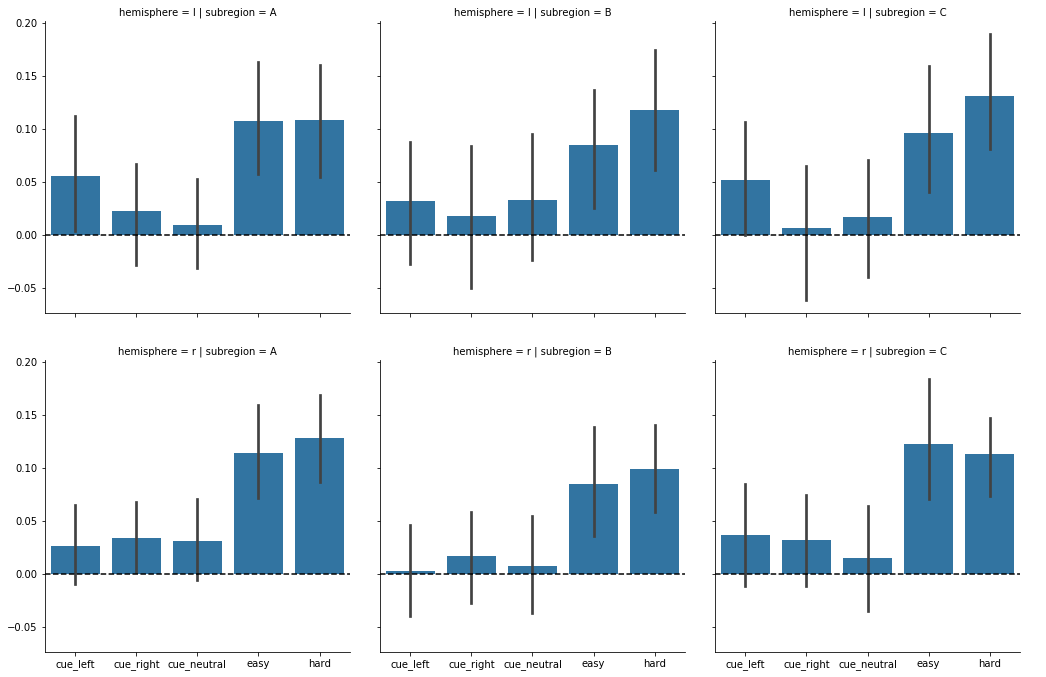

In [557]:
all_betas = pd.concat(gmodel.concat_response_fitters.apply(lambda x: x.betas).values)
all_HRF_betas = all_betas.query('regressor == "HRF"')

# reshape/melt
tmp = all_HRF_betas.reset_index().melt(id_vars=['event type', 'covariate', 'regressor'], var_name='roi', value_name='beta')
tmp['hemisphere'] = tmp['roi'].str.split('_').apply(lambda x: x[1])
tmp['subregion'] = tmp['roi'].str.split('_').apply(lambda x: x[2])

### plot
fac = sns.FacetGrid(tmp, row='hemisphere', col='subregion')

fac.map_dataframe(sns.barplot,
                  x='event type',
#                   hue='event type',
                  y='beta', order=['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'])
#                   color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(15,10)